# Exploratory Data Analysis - Structure

1. **[Lighting Strike Data](#sample1)**
2. **[Structuring Unicorn Companies](#unicorn)**


In this notebook, you will practice structuring, an **exploratory data analysis (EDA)** step that helps data science projects move forward. During EDA, when working with data that contains aspects of date and time, "datetime" transformations are integral to better understanding the data.

Structuring: Process of taking raw data and organizing or transforming it to be more easily visualized, explained or modeled.

<a id="sample1"> </a>
## Lighting Strike Data

### Overview

In this notebook, we will examine lightning strike data collected by the National Oceanic and Atmospheric Association (NOAA) for the year of 2018. To complete this notebook, we will:

* Find the locations with the greatest number of strikes within a single day
* Examine the locations that had the greatest number of days with at least one lightning strike 
* Determine whether certain days of the week had more lightning strikes than others  
* Add data from 2016 and 2017 and, for each month, calculate the percentage of total lightning strikes for that year that occurred in that month
* Plot this data on a bar graph

In [21]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

In [22]:
# File needs to be downloaded from here -> https://drive.google.com/file/d/1WvgLWEaXG12A1YPTF3mD7431sALoZ25j/view?usp=sharing

# Read in the lightning strike dataset.
df = pd.read_csv('datasets/eda_lighting.csv')

# Inspect the first 10 rows.
df.head(10)

,date,number_of_strikes,center_point_geom
0,2016-08-05,16,POINT(-101.5 24.7)
1,2016-08-05,16,POINT(-85 34.3)
2,2016-08-05,16,POINT(-89 41.4)
3,2016-08-05,16,POINT(-89.8 30.7)
4,2016-08-05,16,POINT(-86.2 37.9)
5,2016-08-05,16,POINT(-97.8 38.9)
6,2016-08-05,16,POINT(-81.9 36)
7,2016-08-05,16,POINT(-90.9 36.7)
8,2016-08-05,16,POINT(-106.6 26.1)
9,2016-08-05,16,POINT(-108 31.6)


In [23]:
# Convert date column to datetime
df['date']= pd.to_datetime(df['date'])

# Reduce Dataset to only 2018
df['year'] = df['date'].dt.year
df_2018 = df[df['year'] == 2018]

df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3401012 entries, 18965 to 10479002
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   number_of_strikes  int64         
 2   center_point_geom  object        
 3   year               int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 116.8+ MB


In [24]:
print(df_2018.shape)

# Check for duplicates. If the shape of the data is different after running this code, you will know there were duplicate rows.
df_2018.drop_duplicates().shape

(3401012, 4)


(3401012, 4)

### Locations with most strikes in a single day

To identify the locations with the most strikes in a single day, we will sort the `number_of_strikes` column in descending value, or by most to least strikes.

In [25]:
# Sort by number of strikes in descending order.
df_2018.sort_values(by='number_of_strikes', ascending=False).head(10)

,date,number_of_strikes,center_point_geom,year
2167347,2018-08-20,2211,POINT(-92.5 35.5),2018
4260229,2018-08-16,2142,POINT(-96.1 36.1),2018
6356003,2018-08-17,2061,POINT(-90.2 36.1),2018
7404862,2018-08-17,2031,POINT(-89.9 35.9),2018
70627,2018-08-16,1902,POINT(-96.2 36.1),2018
43963,2018-02-10,1899,POINT(-95.5 28.1),2018
6355660,2018-08-16,1878,POINT(-89.7 31.5),2018
1092942,2018-02-25,1833,POINT(-98.7 28.9),2018
1118721,2018-08-17,1767,POINT(-90.1 36),2018
3186160,2018-02-25,1741,POINT(-98 29),2018


### Locations with most days with at least one lightning strike

To find the number of days that a given geographic location had at least one lightning strike, we will use the `value_counts()` function on the `center_point_geom` column. The logic is that if each row represents a location-day, then counting the number of times each location occurs in the data will give you the number of days that location had lightning. 

In [26]:
# Identify the locations that appear most in the dataset.
df_2018.center_point_geom.value_counts()

center_point_geom
POINT(-84.1 22.4)     108
POINT(-81.5 22.5)     108
POINT(-82.7 22.9)     107
POINT(-82.5 22.9)     107
POINT(-82.5 22.8)     106
                     ... 
POINT(-131.3 46.4)      1
POINT(-128.9 47)        1
POINT(-66.2 48.4)       1
POINT(-65 44.7)         1
POINT(-72.9 23)         1
Name: count, Length: 170855, dtype: int64

The locations with the most days with lightning strikes had at least one strike on 108 days—nearly one out of every three days of the year. These locations are all rather close to each other geographically. Notice also that the `value_counts()` function automatically sorts the results in descending order. 

Now we will examine whether there is an even distribution of values, or whether 108 strikes is an unusually high number of days with lightning strikes. We will use the `value_counts()` function again, but this time we will output the top 20 results. We will also rename the columns and apply a color gradient.

In [28]:
# Identify the top 20 locations with most days of lightning.
df_2018.center_point_geom.value_counts()[:20].rename_axis('unique_values').reset_index(name='counts').style.background_gradient()

,unique_values,counts
0,POINT(-84.1 22.4),108
1,POINT(-81.5 22.5),108
2,POINT(-82.7 22.9),107
3,POINT(-82.5 22.9),107
4,POINT(-82.5 22.8),106
5,POINT(-84.2 22.3),106
6,POINT(-76 20.5),105
7,POINT(-75.9 20.4),105
8,POINT(-78 18.2),104
9,POINT(-82.2 22.9),104


###  Lightning strikes by day of week

One useful grouping is categorizing lightning strikes by day of the week, which will tell us whether any particular day of the week had fewer or more lightning strikes than others. To calculate this, we will take advantage of the fact that the data in our `date` column is of the `datetime` class. Because these entries are datetime objects, we can extract date-related information from them and create new columns.

First, we will create a column called `week` using `dt.isocalendar()` on the `date` column. This function is designed to be used on a pandas series, and it will return a new dataframe with year, week, and day columns. The information is formatted numerically; for example, January 3, 1950, would be represented as:

| Year | Week | Day |
| ---- | :--: | :-: |
| 1950 | 1    | 3   |

Because we only want to extract the week number, we will add `.week` to the end. You can learn more about `dt.isocalendar()` in the [pandas.Series.dt.isocalendar documentation](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.Series.dt.isocalendar.html).

We will also add a `weekday` column using `dt.day_name()`. This is another pandas function designed to be used on a pandas series. It extracts the text name of the day for any given datetime date. You can learn more about this function in the [pandas.Series.dt.day_name documentation](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.Series.dt.day_name.html).


In [31]:
# Create two new columns.
df_2018['week'] = df_2018.date.dt.isocalendar().week
df_2018['weekday'] = df_2018.date.dt.day_name()
df_2018.head()

/var/folders/1h/3xv2s5v153548qm156_k0h400000gn/T/ipykernel_79603/253781021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['week'] = df_2018.date.dt.isocalendar().week
/var/folders/1h/3xv2s5v153548qm156_k0h400000gn/T/ipykernel_79603/253781021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['weekday'] = df_2018.date.dt.day_name()


,date,number_of_strikes,center_point_geom,year,week,weekday
18965,2018-05-27,13,POINT(-81.1 22.8),2018,21,Sunday
18966,2018-05-27,13,POINT(-108.6 42.8),2018,21,Sunday
18967,2018-05-27,13,POINT(-104.6 41.8),2018,21,Sunday
18968,2018-05-27,13,POINT(-81.3 24.8),2018,21,Sunday
18969,2018-05-27,13,POINT(-105.3 43.6),2018,21,Sunday


In [32]:
# Now, we can calculate the mean number of lightning strikes for each weekday of the year. We will use the `groupby()` function to do this.

# Calculate the mean count of lightning strikes for each weekday.
df_2018[['weekday','number_of_strikes']].groupby(['weekday']).mean()

,number_of_strikes
weekday,
Friday,13.349972
Monday,13.152804
Saturday,12.732694
Sunday,12.324717
Thursday,13.240594
Tuesday,13.813599
Wednesday,13.224568


It seems that Saturday and Sunday have fewer lightning strikes on average than the other five weekdays. We will plot the distributions of the strike counts for each day of the week. We want each distribution to be represented as a boxplot. 

We will begin by defining the order of the days, starting with Monday and ending with Sunday. This is how the days will be ordered in the plot we create.

In [33]:
# Define order of days for the plot.
weekday_order = ['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

Now, we will code the plot. Remember that `showfliers` is the parameter that controls whether or not outliers are displayed in the plot. If we input `True`, outliers are included; if we input `False`, outliers are left off of the box plot. Keep in mind, we aren’t *deleting* any outliers from the dataset when we create this chart—we are only excluding them from the visualization.

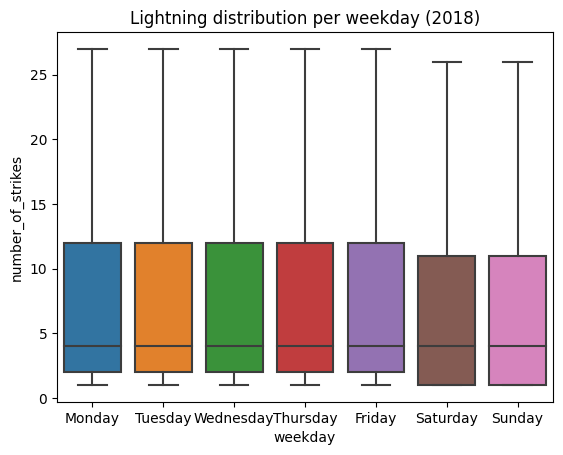

In [34]:
# Create boxplots of strike counts for each day of week.
g = sns.boxplot(data=df_2018, 
            x='weekday',
            y='number_of_strikes', 
            order=weekday_order, 
            showfliers=False 
            );
g.set_title('Lightning distribution per weekday (2018)');

Notice that the median remains the same on all of the days of the week. As for Saturday and Sunday, however, the distributions are *both* lower than they are during the rest of the week. We also know that the mean numbers of strikes that occurred on Saturday and Sunday were lower than on the other weekdays. Why might this be? Perhaps the aerosol particles emitted by factories and vehicles increase the likelihood of lightning strikes. In the U.S., Saturday and Sunday are days that many people don't work, so there may be fewer factories operating and fewer cars on the road. This is only speculation, but it's one possible path for further exploration. 

### Monthly lightning strikes 2016–2018

Finally, we will examine monthly lightning strike data from 2016–2018. We will calculate the percentage of total lightning strikes for each year that occurred in a given month. We will then plot this data on a bar graph.

In [35]:
# Add 2 new columns.
df['month'] = df.date.dt.month
df['month_txt'] = df.date.dt.month_name()
df.head()

,date,number_of_strikes,center_point_geom,year,month,month_txt
0,2016-08-05,16,POINT(-101.5 24.7),2016,8,August
1,2016-08-05,16,POINT(-85 34.3),2016,8,August
2,2016-08-05,16,POINT(-89 41.4),2016,8,August
3,2016-08-05,16,POINT(-89.8 30.7),2016,8,August
4,2016-08-05,16,POINT(-86.2 37.9),2016,8,August


In [36]:
# Calculate total number of strikes per year
df[['year','number_of_strikes']].groupby(['year']).sum(numeric_only=True)

,number_of_strikes
year,
2016,41582229
2017,35095195
2018,44600989


Now we will calculate the percentage of total lightning strikes that occurred in a given month for each year and assign the results to a new dataframe called `lightning_by_month`. 

In [38]:
# Calculate total lightning strikes for each month of each year.
lightning_by_month = df.groupby(['month_txt','year']).agg(
    number_of_strikes = pd.NamedAgg(column='number_of_strikes',aggfunc=sum)
    ).reset_index()

lightning_by_month.head()

,month_txt,year,number_of_strikes
0,April,2016,2636427
1,April,2017,3819075
2,April,2018,1524339
3,August,2016,7250442
4,August,2017,6021702


We can use the `agg()` function to calculate the same yearly totals we found before, with 2017 having fewer strikes than the other two years.

In [40]:
# Calculate total lightning strikes for each year.
lightning_by_year = df.groupby(['year']).agg(
  year_strikes = pd.NamedAgg(column='number_of_strikes',aggfunc=sum)
).reset_index()

lightning_by_year.head()

,year,year_strikes
0,2016,41582229
1,2017,35095195
2,2018,44600989


In our bar plot, we need to use the monthly totals to calculate percentages. For each month, we will need the monthly total strike count and the total strike count for that year. Let's create another dataframe called `percentage_lightning` that adds a new column called `year_strikes` which represents the total number of strikes for each year. We can do this using the `merge()` function. We will merge the `lightning_by_month` dataframe with the `lightning_by_year` dataframe, specifying to merge on the `year` column. This means that wherever the `year` columns contain the same value in both dataframes, a row is created in our new dataframe with all the other columns from both dataframes being merged. To learn more about this function, refer to the [pandas.merge documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

In [41]:
# Combine `lightning_by_month` and `lightning_by_year` dataframes into single dataframe.
percentage_lightning = lightning_by_month.merge(lightning_by_year,on='year')
percentage_lightning.head()

,month_txt,year,number_of_strikes,year_strikes
0,April,2016,2636427,41582229
1,August,2016,7250442,41582229
2,December,2016,316450,41582229
3,February,2016,312676,41582229
4,January,2016,313595,41582229


Now we will create a new column in our new dataframe that represents the percentage of total lightning strikes that occurred during each month for each year. We will do this by dividing the `number_of_strikes` column by the `year_strikes` column and multiplying the result by 100.

In [42]:
# Create new `percentage_lightning_per_month` column.
percentage_lightning['percentage_lightning_per_month'] = (percentage_lightning.number_of_strikes/
                                                          percentage_lightning.year_strikes * 100.0)
percentage_lightning.head()

,month_txt,year,number_of_strikes,year_strikes,percentage_lightning_per_month
0,April,2016,2636427,41582229,6.340273
1,August,2016,7250442,41582229,17.436396
2,December,2016,316450,41582229,0.761022
3,February,2016,312676,41582229,0.751946
4,January,2016,313595,41582229,0.754156


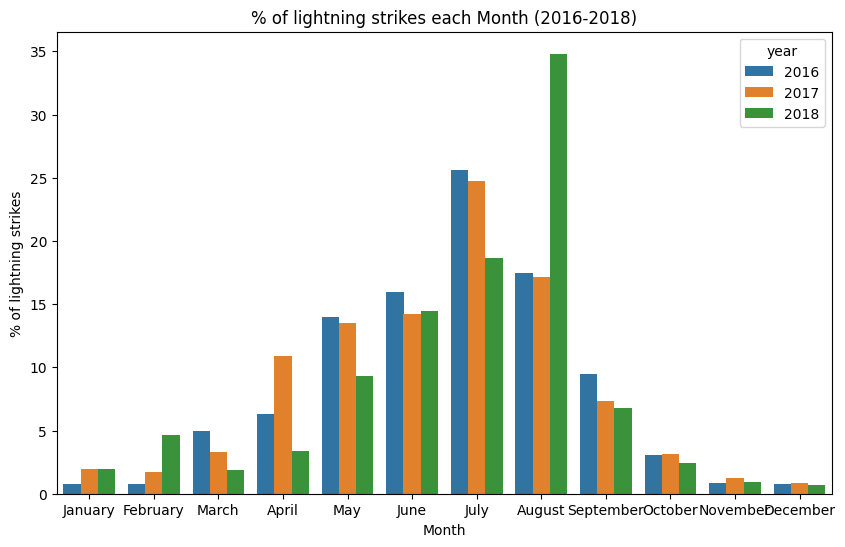

In [43]:
# Now we can plot the percentages by month in a bar graph.

plt.figure(figsize=(10,6));

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

sns.barplot(
    data = percentage_lightning,
    x = 'month_txt',
    y = 'percentage_lightning_per_month',
    hue = 'year',
    order = month_order );
plt.xlabel("Month");
plt.ylabel("% of lightning strikes");
plt.title("% of lightning strikes each Month (2016-2018)");

For all three years, there is a clear pattern over the course of each year. One month stands out: August. More than one third of the lightning strikes in 2018 happened in August. 

<a id="unicorn"></a>
## Structuring Unicorn Companies

In this activity, you are a member of an analytics team that provides insights to an investing firm. To help them decide which companies to invest in next, the firm wants insights into **unicorn companies**–companies that are valued at over one billion dollars.  

In [44]:
# Import the relevant Python libraries and modules needed in this lab.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
# Load the dataset provided into a DataFrame.
companies = pd.read_csv("datasets/Unicorn_Companies.csv")

# Display the first 10 rows of the data.
companies.head(10)

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors
0,Bytedance,$180B,4/7/17,Artificial intelligence,Beijing,China,Asia,2012,$8B,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,$100B,12/1/12,Other,Hawthorne,United States,North America,2002,$7B,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,$100B,7/3/18,E-commerce & direct-to-consumer,Shenzhen,China,Asia,2008,$2B,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,$95B,1/23/14,Fintech,San Francisco,United States,North America,2010,$2B,"Khosla Ventures, LowercaseCapital, capitalG"
4,Klarna,$46B,12/12/11,Fintech,Stockholm,Sweden,Europe,2005,$4B,"Institutional Venture Partners, Sequoia Capita..."
5,Canva,$40B,1/8/18,Internet software & services,Surry Hills,Australia,Oceania,2012,$572M,"Sequoia Capital China, Blackbird Ventures, Mat..."
6,Checkout.com,$40B,5/2/19,Fintech,London,United Kingdom,Europe,2012,$2B,"Tiger Global Management, Insight Partners, DST..."
7,Instacart,$39B,12/30/14,"Supply chain, logistics, & delivery",San Francisco,United States,North America,2012,$3B,"Khosla Ventures, Kleiner Perkins Caufield & By..."
8,JUUL Labs,$38B,12/20/17,Consumer & retail,San Francisco,United States,North America,2015,$14B,Tiger Global Management
9,Databricks,$38B,2/5/19,Data management & analytics,San Francisco,United States,North America,2013,$3B,"Andreessen Horowitz, New Enterprise Associates..."


In [50]:
# Identify the number of rows and columns in the dataset.
print(companies.shape)

# Check for duplicates.
companies.drop_duplicates().shape

(1074, 10)


(1074, 10)

**Question:** How many rows and columns are in the dataset? How many unicorn companies are there? How many aspects are shown for each company?

- There are 1074 rows and 10 columns in the dataset.
- According to this dataset, there are 1074 unicorn companies, as of March 2022. 
- This dataset shows 10 aspects of each company. 

**Question:** Based on the preceding output, are there any duplicates in the dataset?

- Since the shape that is returned after dropping duplicates is the same as the shape of the original DataFrame, you can infer that there are no duplicate values in the dataset. 

### Display the data types of the columns 

Knowing the data types of the columns is helpful because it indicates what types of analysis and aggregation can be done, how a column can be transformed to suit specific tasks, and so on. Display the data types of the columns. 

In [51]:
# Display the data types of the columns.
companies.dtypes

Company             object
Valuation           object
Date Joined         object
Industry            object
City                object
Country/Region      object
Continent           object
Year Founded         int64
Funding             object
Select Investors    object
dtype: object

**Question:** What do you notice about the data types of the columns in the dataset?

- The data type of the `Year Founded` column is `int64`. 
- The rest of the columns have the data type `object`.

**Question:** How would you sort this dataset in order to get insights about when the companies were founded? Then, how would you arrange the data from companies that were founded the earliest to companies that were founded the latest?

- Sort by `Year Founded`.
  - Sort by `Year Founded` in ascending order to arrange the data from companies that were founded the earliest to companies that were founded the latest.


### Sort the data

In this section, you will continue your exploratory data analysis by structuring the data. This is an important step in EDA, as it allows you to glean valuable and interesting insights about the data afterwards.

To begin, sort the data so that you can get insights about when the companies were founded. Consider whether it would make sense to sort in ascending or descending order based on what you would like to find.

In [52]:
# Sort `companies` and display the first 10 rows of the resulting DataFrame.
# To arrange the data from latest to earliest `Year Founded`
companies.sort_values(by="Year Founded", ascending=False).head(10)

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors
782,Phantom,$1B,1/31/22,Fintech,San Francisco,United States,North America,2021,$118M,"Paradigm, Andreessen Horowitz, Jump Capital"
714,Yidian Zixun,$1B,10/17/17,Mobile & telecommunications,Beijing,China,Asia,2021,$151M,"Phoenix New Media, Tianjin Haihe Industry Fund"
822,GlobalBees,$1B,12/28/21,E-commerce & direct-to-consumer,New Delhi,India,Asia,2021,$185M,"Chiratae Ventures, SoftBank Group, Trifecta Ca..."
554,ClickHouse,$2B,10/28/21,Data management & analytics,Portola Valley,United States,North America,2021,$300M,"Lightspeed Venture Partners, Almaz Capital Par..."
952,LayerZero Labs,$1B,3/30/22,Internet software & services,New York,United States,North America,2021,$143M,"Andreessen Horowitz, FTX Ventures, Tiger Globa..."
314,Flink Food,$3B,12/1/21,E-commerce & direct-to-consumer,Berlin,Germany,Europe,2021,$1B,"Mubadala Capital, Bond, Prosus Ventures"
864,Aptos,$1B,3/15/22,Internet software & services,Palo Alto,United States,North America,2021,$200M,"Andreessen Horowitz, Coinbase Ventures, Tiger ..."
238,Yuga Labs,$4B,3/22/22,Fintech,Miami,United States,North America,2021,$450M,"Andreessen Horowitz, Thrive Capital, Sound Ven..."
775,Jokr,$1B,12/2/21,E-commerce & direct-to-consumer,New York,United States,North America,2021,$430M,"GGV Capital, Tiger Global Management, Greycroft"
967,Mensa Brands,$1B,11/16/21,Other,Bengaluru,India,Asia,2021,$218M,"Accel, Falcon Edge Capital, Norwest Venture Pa..."


**Question:** What do you observe from the sorting that you performed?

- If you sorted by `Year Founded` in descending order and displayed the first 10 rows of the resulting DataFrame, you might observe the following:
  - These 10 rows correspond to unicorn companies that were founded in 2021. 
  - These 10 companies were founded in different parts of the world and belong to different industries. 
  - Many of these 10 companies were founded in the United States and belong to "Fintech," "E-commerce & direct-to-consumer," and "Internet software & services" industries. 

  **Question:** Which library would you use to get the count of each distinct value in the `Year Founded` column? 

- Use a function from the `pandas` library to get the count of each distinct value in the `Year Founded` column. Each count would indicate how many companies in the dataset were founded in the corresponding year.

### Determine the number of companies founded each year

Find out how many companies in this dataset were founded each year. Make sure to display each unique `Year Founded` that occurs in the dataset, and for each year, a number that represents how many companies were founded then.

In [53]:
# Display each unique year that occurs in the dataset along with the number of companies that were founded in each unique year.
companies["Year Founded"].value_counts().sort_values(ascending=False)

Year Founded
2015    155
2016    110
2014    109
2012     95
2013     87
2011     82
2017     74
2018     61
2019     45
2010     40
2009     34
2008     27
2020     25
2007     24
2006     15
2005     14
2000     11
2021     11
2001      9
1999      8
2004      8
2003      8
1998      5
2002      4
1994      2
1995      2
1992      1
1993      1
1990      1
1984      1
1996      1
1979      1
1991      1
1919      1
1997      1
Name: count, dtype: int64

**Question:** What do you observe from the counts of the unique `Year Founded` values in the dataset?

- `2015` has the highest count. This indicates that `2015` is the year when the largest number of companies in this dataset were founded.

**Question:** What kind of graph represents the counts of samples based on a particular feature?

- A histogram is a graphical representation of a frequency distribution, which shows how frequently each value in a dataset or variable occurs.


Plot a histogram of the `Year Founded` feature.

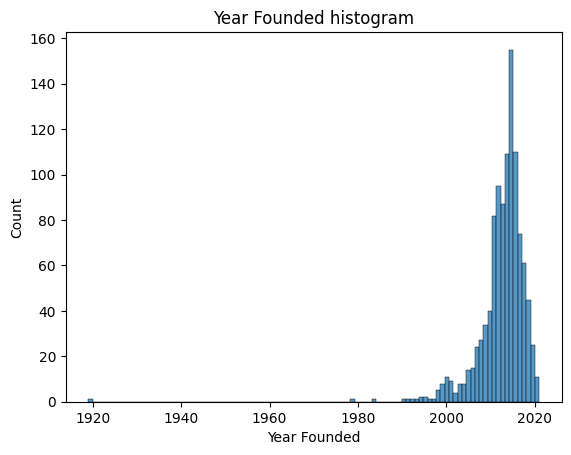

In [54]:
sns.histplot(data=companies, x='Year Founded')
plt.title('Year Founded histogram');

**Question:** If you want to compare when one company joined unicorn status to when another company joined, how would you transform the `Date Joined` column to gain that insight? To answer this question, notice the data types.

- Given that the `Date Joined` columns currently has the data type `object`, if you wanted to compare when one company joined unicorn status to when another company joined, it would not be possible to achieve this meaningfully, as is. If this column were transformed so that it had a `datetime` data type instead, then it could be used to meaningfully compare `Date Joined` of one company to another. 


### Convert the `Date Joined` column to datetime

Convert the `Date Joined` column to datetime. This will split each value into year, month, and date components, allowing you to later gain insights about when a company gained unicorn status with respect to each component.

In [55]:
# Convert `Date Joined` column to datetime.
# Update the column with the converted values.
companies["Date Joined"] = pd.to_datetime(companies["Date Joined"])


# Display the data types of the columns in `companies`
# to confirm that the update actually took place
companies.dtypes

/var/folders/1h/3xv2s5v153548qm156_k0h400000gn/T/ipykernel_79603/2529602256.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  companies["Date Joined"] = pd.to_datetime(companies["Date Joined"])


Company                     object
Valuation                   object
Date Joined         datetime64[ns]
Industry                    object
City                        object
Country/Region              object
Continent                   object
Year Founded                 int64
Funding                     object
Select Investors            object
dtype: object

**Question:** How would you obtain the names of the months when companies gained unicorn status?

- Now that the `Date Joined` column is in datetime format, extract the month name from each each value in `Date Joined`. This helps obtain the names of the months when companies attained unicorn status.

### Create a `Month Joined` column

Obtain the names of the months when companies gained unicorn status, and use the result to create a `Month Joined` column.

In [56]:
# Obtain the names of the months when companies gained unicorn status.
# Use the result to create a `Month Joined` column.
companies["Month Joined"] = companies["Date Joined"].dt.month_name()


# Display the first few rows of `companies`
# to confirm that the new column did get added.
companies.head()

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors,Month Joined
0,Bytedance,$180B,2017-04-07,Artificial intelligence,Beijing,China,Asia,2012,$8B,"Sequoia Capital China, SIG Asia Investments, S...",April
1,SpaceX,$100B,2012-12-01,Other,Hawthorne,United States,North America,2002,$7B,"Founders Fund, Draper Fisher Jurvetson, Rothen...",December
2,SHEIN,$100B,2018-07-03,E-commerce & direct-to-consumer,Shenzhen,China,Asia,2008,$2B,"Tiger Global Management, Sequoia Capital China...",July
3,Stripe,$95B,2014-01-23,Fintech,San Francisco,United States,North America,2010,$2B,"Khosla Ventures, LowercaseCapital, capitalG",January
4,Klarna,$46B,2011-12-12,Fintech,Stockholm,Sweden,Europe,2005,$4B,"Institutional Venture Partners, Sequoia Capita...",December


**Question:** Using the `Date Joined` column, how would you determine how many years it took for companies to reach unicorn status?

- Given that the `Date Joined` column is in datetime format, extract the year component from `Date Joined` and subtract the `Year Founded` column from it. This difference in years represents how many it years it took for companies to reach unicorn status.

### Create a `Years To Join` column

Determine how many years it took for companies to reach unicorn status, and use the result to create a `Years To Join` column. Adding this to the dataset can help you answer questions you may have about this aspect of the companies.

In [57]:
# Determine how many years it took for companies to reach unicorn status.
# Use the result to create a `Years To Join` column.
companies["Years To Join"] = companies["Date Joined"].dt.year - companies["Year Founded"]


# Display the first few rows of `companies`
# to confirm that the new column did get added.
companies.head()

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors,Month Joined,Years To Join
0,Bytedance,$180B,2017-04-07,Artificial intelligence,Beijing,China,Asia,2012,$8B,"Sequoia Capital China, SIG Asia Investments, S...",April,5
1,SpaceX,$100B,2012-12-01,Other,Hawthorne,United States,North America,2002,$7B,"Founders Fund, Draper Fisher Jurvetson, Rothen...",December,10
2,SHEIN,$100B,2018-07-03,E-commerce & direct-to-consumer,Shenzhen,China,Asia,2008,$2B,"Tiger Global Management, Sequoia Capital China...",July,10
3,Stripe,$95B,2014-01-23,Fintech,San Francisco,United States,North America,2010,$2B,"Khosla Ventures, LowercaseCapital, capitalG",January,4
4,Klarna,$46B,2011-12-12,Fintech,Stockholm,Sweden,Europe,2005,$4B,"Institutional Venture Partners, Sequoia Capita...",December,6


**Question:** Which year would you like to gain more insight on with respect when companies attained unicorn status, and why?

- Get more insight on the year 2021, as that is the most recent year for which there is data available. Trends that took place in 2021 might be similar to trends that will take place in 2022. 

### Gain more insight on a specific year

To get more insight on the year of that interests you, filter the dataset by that year and save the resulting subset into a new variable. 

In [58]:
# Filter dataset by a year of your interest (in terms of when companies reached unicorn status).
# Save the resulting subset in a new variable .
companies_2021 = companies[companies["Date Joined"].dt.year == 2021]

# Display the first few rows of the subset to confirm that it was created
companies_2021.head()

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors,Month Joined,Years To Join
12,FTX,$32B,2021-07-20,Fintech,NaN,Bahamas,North America,2018,$2B,"Sequoia Capital, Thoma Bravo, Softbank",July,3
16,J&T Express,$20B,2021-04-07,"Supply chain, logistics, & delivery",Jakarta,Indonesia,Asia,2015,$5B,"Hillhouse Capital Management, Boyu Capital, Se...",April,6
24,Blockchain.com,$14B,2021-02-17,Fintech,London,United Kingdom,Europe,2011,$490M,"Lightspeed Venture Partners, Google Ventures, ...",February,10
27,OpenSea,$13B,2021-07-20,E-commerce & direct-to-consumer,New York,United States,North America,2017,$427M,"Andreessen Horowitz, Thirty Five Ventures, Sou...",July,4
34,Getir,$12B,2021-03-26,E-commerce & direct-to-consumer,Istanbul,Turkey,Europe,2015,$2B,"Tiger Global Management, Sequoia Capital, Revo...",March,6


**Question:** Using a time interval, how could you observe trends in the companies that became unicorns in one year?

- First, identify a time interval of your choice. Then, take the subset that consists of the data for the year of interest, create a column that contains the time interval that each data point belongs to (as needed), group by that column, and count the number of companies that joined per interval. 
  - For example, if a subset consisted of companies that joined in 2021, create a column that corresponds to week joined, group by week, and count the number of companies that joined per week. This allows the observation of trends over the weeks of 2021. 


### Observe trends over time

Implement the structuring approach that you have identified to observe trends over time in the companies that became unicorns for the year that interests you.

In [59]:
# After identifying the time interval that interests you, proceed with the following:
# Step 1. Take the subset that you defined for the year of interest. 
#         Insert a column that contains the time interval that each data point belongs to, as needed.
# Step 2. Group by the time interval.
#         Aggregate by counting companies that joined per interval of that year.
#         Save the resulting DataFrame in a new variable.

# Insert a `Week Joined` column into `companies_2021.`
companies_2021.insert(3, "Week Joined", companies_2021["Date Joined"].dt.strftime('%Y-W%V'), True)

# Group `companies_2021` by `Week Joined`. 
# Aggregate by counting companies that joined per week of 2021.
# Save the resulting DataFrame in a new variable.
companies_by_week_2021 = companies_2021.groupby(by="Week Joined")["Company"].count().reset_index().rename(columns={"Company":"Company Count"})

# Display the first few rows of the new DataFrame to confirm that it was created.
companies_by_week_2021.head()

,Week Joined,Company Count
0,2021-W01,12
1,2021-W02,9
2,2021-W03,5
3,2021-W04,8
4,2021-W05,4


**Question:** How would you structure the data to observe trends in the average valuation of companies from 2020 to 2021?  

- One approach consists of the following:
  - Choose a time interval over which you want to observe average valuation.
  - Create a subset of data that corresponds to the additional year. Concatenate that subset with the previous subset you created, in order to get the data for both years in one DataFrame. 
  - Create a column that contains the time interval that each data point belongs to (as needed), group by that column, and compute the average funding of companies that joined per interval. 
- To compare trends in average valuation of companies quarterly between 2021 and 2020, if you already had a subset for 2021, you could do the following: 
- Create a subset for 2020.
- Concatenate that with the subset for 2020.
- Create a column that corresponds to quarter joined.
- Group by quarter.
- Compute the average valuation of companies that joined per quarter. 

This allows the observation of trends over the quarters of 2020 compared to 2021. 


### Compare trends over time

Implement the structuring approach that you have identified in order to compare trends over time in the average valuation of companies that became unicorns between your years of interest. Keep in mind the data type of the `Valuation` column and what the values in that column contain currently.

In [60]:
# After identifying the additional year and time interval of interest, proceed with the following:
# Step 1. Filter by the additional year to create a subset that consists of companies that joined in that year.
# Step 2. Concatenate that new subset with the subset that you defined previously.
# Step 3. As needed, add a column that contains the time interval that each data point belongs to, 
#         in the concatenated DataFrame.
# Step 4. Transform the `Valuation` column as needed.
# Step 5. Group by the time interval.
#         Aggregate by computing average valuation of companies that joined per interval of the corresponding year.
#         Save the resulting DataFrame in a new variable.

# Filter by the additional year to create a subset that consists of companies that joined in that year.
companies_2020 = companies[companies["Date Joined"].dt.year == 2020]

# Concatenate the new subset with the subset that you defined previously.
companies_2020_2021 = pd.concat([companies_2020, companies_2021.drop(columns="Week Joined")])

# Add `Quarter Joined` column to `companies_2021`.
companies_2020_2021["Quarter Joined"] = companies_2020_2021["Date Joined"].dt.to_period('Q').dt.strftime('%Y-Q%q')

# Convert the `Valuation` column to numeric by removing `$` and `B` and casting each value to data type `float`.
companies_2020_2021["Valuation"] =  companies_2020_2021["Valuation"].str.strip("$B").astype(float)

# Group `companies_2020_2021` by `Quarter Joined`, 
# Aggregate by computing average `Funding` of companies that joined per quarter of each year.
# Save the resulting DataFrame in a new variable.
companies_by_quarter_2020_2021 = companies_2020_2021.groupby(by="Quarter Joined")["Valuation"].mean().reset_index().rename(columns={"Valuation":"Average Valuation"})

# Display the first few rows of the new DataFrame to confirm that it was created.

companies_by_quarter_2020_2021.head()

,Quarter Joined,Average Valuation
0,2020-Q1,3.444444
1,2020-Q2,3.777778
2,2020-Q3,3.896552
3,2020-Q4,3.697674
4,2021-Q1,2.750000


## Step 3: Time-to-unicorn visualization

### Visualize the time it took companies to become unicorns

As a next step, visualize your data. Using the `companies` dataset, create a box plot to visualize the distribution of how long it took companies to become unicorns, with respect to the month they joined. 

In [62]:
# Define a list that contains months in chronological order.
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", 
               "December"]

# Print out the list to confirm it is correct.
print(month_order)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


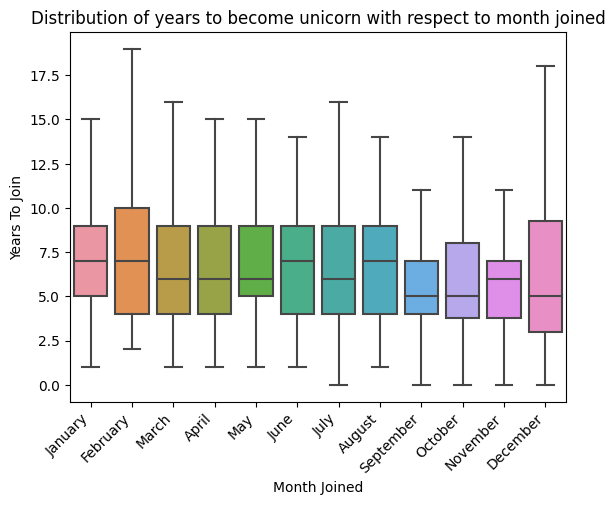

In [63]:
# Create the box plot to visualize the distribution of how long it took companies to become unicorns, with respect to the month they joined.
# Make sure the x-axis goes in chronological order by month, using the list you defined previously.
# Plot the data from the `companies` DataFrame.

### YOUR CODE HERE ###

sns.boxplot(x=companies['Month Joined'], 
            y=companies['Years To Join'], 
            order=month_order, 
            showfliers=False)

# Set the title of the plot.

### YOUR CODE HERE ###

plt.title('Distribution of years to become unicorn with respect to month joined')

# Rotate labels on the x-axis as a way to avoid overlap in the positions of the text. 

### YOUR CODE HERE ###

plt.xticks(rotation=45, horizontalalignment='right')

# Display the plot.

### YOUR CODE HERE ###

plt.show()

**Question:** In the preceding box plot, what do you observe about the median value for `Years To Join` for each month?
 
- In the preceding box plot, the median value for `Years To Join` is different for each month. Also, the median `Years To Join` is lower for the months of September and October. This could indicate that companies that reached unicorn status in early fall took less time to reach $1 billion valuation. This is because the number of companies is relatively close/consistent for each month. If that were not the case, it would be misleading to compare the median values from the box plots between months.

## Step 4: Results and evaluation

### Visualize the time it took companies to reach unicorn status

In this section, you will evaluate the result of structuring the data, making observations, and gaining further insights about the data. 

Using the `companies` dataset, create a bar plot to visualize the average number of years it took companies to reach unicorn status with respect to when they were founded. 

/var/folders/1h/3xv2s5v153548qm156_k0h400000gn/T/ipykernel_79603/3064529079.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=companies["Year Founded"], y=companies["Years To Join"], ci=False)


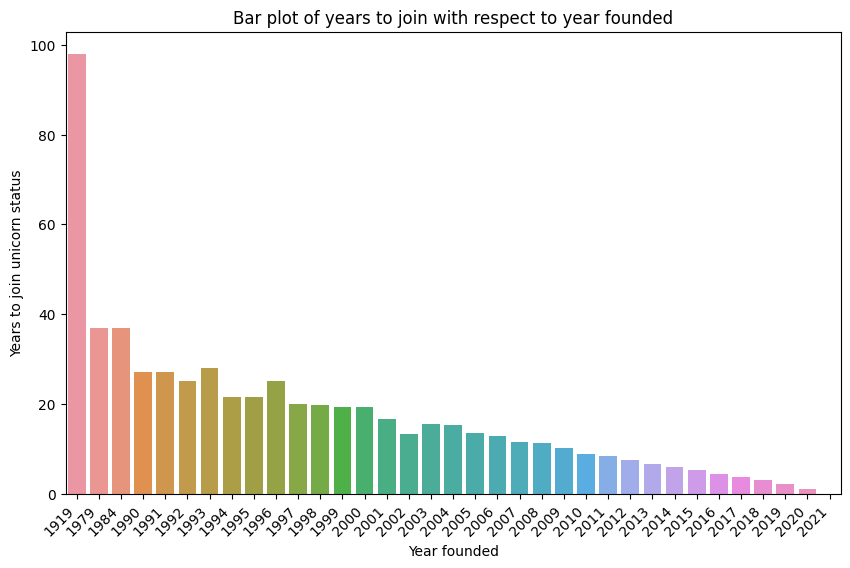

In [64]:
# Set the size of the plot.
plt.figure(figsize=(10,6))


# Create bar plot to visualize the average number of years it took companies to reach unicorn status 
# with respect to when they were founded.
# Plot data from the `companies` DataFrame.

sns.barplot(x=companies["Year Founded"], y=companies["Years To Join"], ci=False)


# Set title
plt.title("Bar plot of years to join with respect to year founded")


# Set x-axis label
plt.xlabel("Year founded")


# Set y-axis label
plt.ylabel("Years to join unicorn status")


# Rotate the labels on the x-axis as a way to avoid overlap in the positions of the text.  
plt.xticks(rotation=45, horizontalalignment='right')

# Display the plot.
plt.show()

**Question:** What trends do you notice in the data? Specifically, consider companies that were founded later on. How long did it take those companies to reach unicorn status?

- There appears to be a trend wherein companies that were founded later took less time to reach unicorn status, on average. 

**Note:** This is a bias that is common in time data—because companies founded in later years have been around for less time. Therefore, there is less time to collect data on such companies compared to companies founded in earlier years). 


### Visualize the number of companies that joined per interval 

Using the subset of companies joined in the year of interest, grouped by the time interval of your choice, create a bar plot to visualize the number of companies that joined per interval for that year.

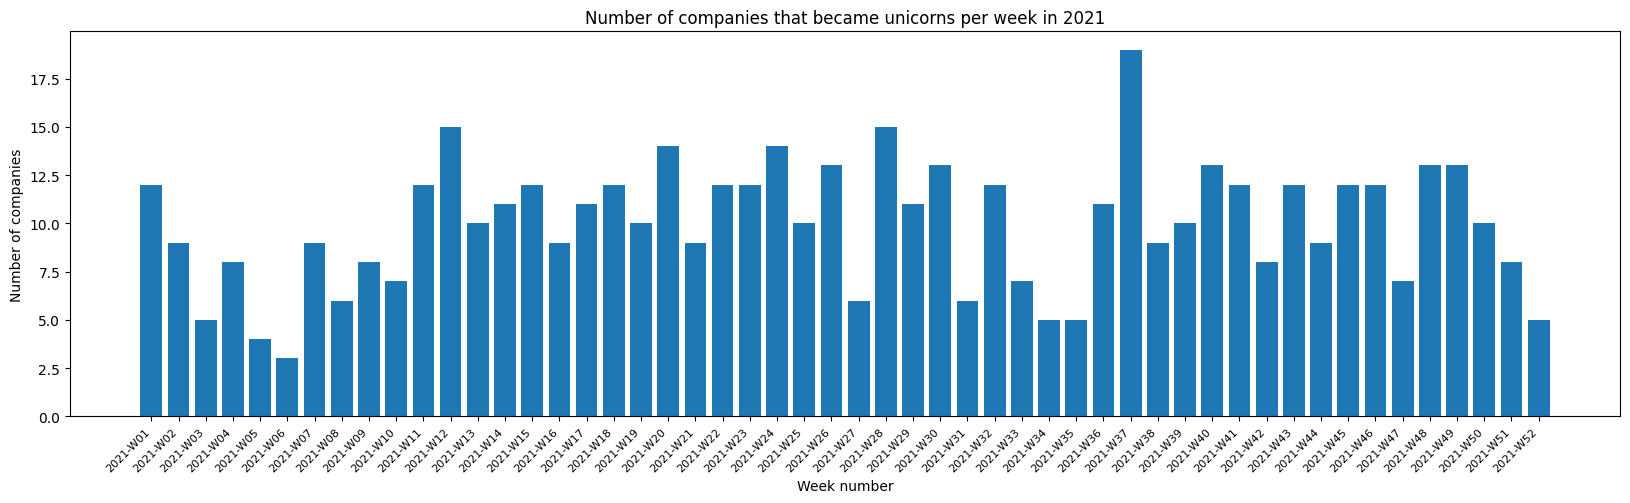

In [65]:
# Set the size of the plot.
plt.figure(figsize = (20, 5))

# Create bar plot to visualize number of companies that joined per interval for the year of interest.
plt.bar(x=companies_by_week_2021['Week Joined'],height=companies_by_week_2021['Company Count'])
plt.plot()

# Set the x-axis label.
plt.xlabel("Week number")

# Set the y-axis label.
plt.ylabel("Number of companies")

# Set the title.
plt.title("Number of companies that became unicorns per week in 2021")

# Rotate the labels on the x-axis as a way to avoid overlap in the positions of the text.  
plt.xticks(rotation = 45, horizontalalignment='right', fontsize=8)

# Display the plot.
plt.show()

**Question:** What do you observe from the bar plot of the number of companies that joined per interval for the year of 2021? When did the highest number of companies reach $1 billion valuation?

- Observations from a bar plot of the number of companies that became unicorns per week in 2021:

  - The number of companies that joined unicorn status fluctuated over the weeks of 2021, with a trend of decline followed by increase occurring periodically.
  - The highest number of companies reached $1 billion valuation in Week 37 of 2021, which corresponds to the third week of September 2021. 
  - The weeks in 2021 with the next highest number of companies becoming unicorns are Week 12 (which corresponds to the fourth week of March) and Week 28 (which corresponds to the third week of July). 
  

### Visualize the average valuation over the quarters

Using the subset of companies that joined in the years of interest, create a grouped bar plot to visualize the average valuation over the quarters, with two bars for each time interval. There will be two bars for each time interval. This allows you to compare quarterly values between the two years.

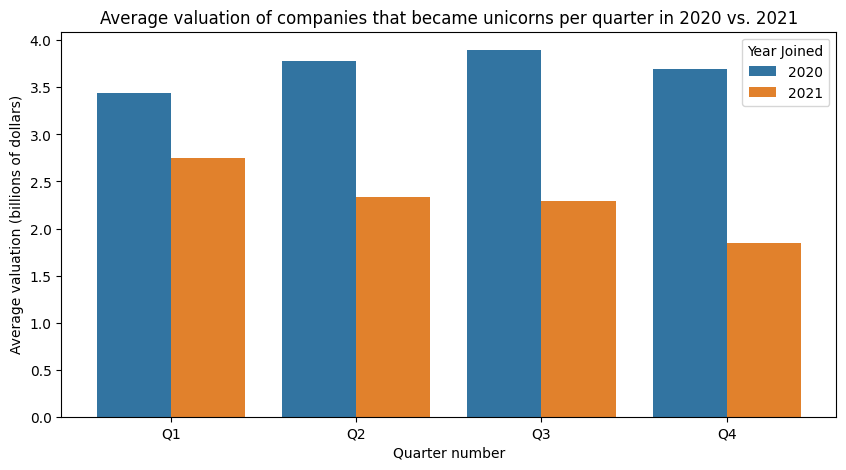

In [66]:
# Using slicing, extract the year component and the time interval that you specified, 
# and save them by adding two new columns into the subset. 

companies_by_quarter_2020_2021['Quarter Number'] = companies_by_quarter_2020_2021['Quarter Joined'].str[-2:]
companies_by_quarter_2020_2021['Year Joined'] = companies_by_quarter_2020_2021['Quarter Joined'].str[:4]

# Set the size of the plot.

plt.figure(figsize = (10, 5))

# Create a grouped bar plot.
sns.barplot(x=companies_by_quarter_2020_2021['Quarter Number'],
            y=companies_by_quarter_2020_2021['Average Valuation'],
            hue=companies_by_quarter_2020_2021['Year Joined'])
plt.plot()

# Set the x-axis label.
plt.xlabel("Quarter number")

# Set the y-axis label.
plt.ylabel("Average valuation (billions of dollars)")

# Set the title.
plt.title("Average valuation of companies that became unicorns per quarter in 2020 vs. 2021")

# Display the plot.
plt.show()

**Question:** What do you observe from the preceding grouped bar plot?

- Observations from a grouped bar plot of average valuation of companies that became unicorns per quarter in 2020 vs. 2021:

  - In each quarter, the average valuation of companies that joined unicorn status was higher in 2020 than in 2021. 
  - In 2020, Q3 was the quarter with the highest average valuation of companies that reached unicorn status, and there was a trend of increase from Q1 to Q2 and from Q2 to Q3. 
  - In 2021, Q1 was the quarter with the highest average valuation of companies that reached unicorn status, and there was a trend of decrease across the quarters.
  

**Question:** Is there any bias in the data that could potentially inform your analysis?

- Potential bias:

  - If there were bias in terms of which cities and countries were taken into account when collecting the data, then the analysis would be more representative of the cities and countries that are in the dataset than those that are not.
  - If the dataset did not include certain industries, then the analysis would be more representative of the industries that are included and may not reflect trends in those that are excluded from the data. 
  - If the dataset had time gaps, (e.g., if companies that joined in certain windows of time were not included in the data), then that may have affected the patterns observed, depending on how salient the gaps were.
  - Another point of bias pertains to the nature of time data; there have been fewer years to collect data on companies that were founded more recently than for companies that were founded longer ago.


**Question:** What potential next steps could you take with your EDA?
 
- Potential next steps with EDA: 

  - Analyze the data with respect to industries of unicorn companies at different datetime intervals.
  - Analyze the data with respect to cities or countries where unicorn companies were founded at different datetime intervals.
  - Clean the data as needed.


**Question:** Are there any unanswered questions you have about the data? If yes, what are they?

- Possible questions:

  - How many rounds of funding did each company require and when did this funding take place?
  - Have any of these unicorn companies acquired other companies along the way? If so, which companies acquired other companies, which companies did they acquire, and when did the acquisitions take place?

## Considerations

**What are some key takeaways that you learned from this lab?**

- Functions in the `pandas` library can be used for data manipulation in order to reorganize and structure the data.
- Converting strings that contain dates to datetime format allow you to extract individual components from the data, such as month and year.
- Structuring the data in specific ways allows you to observe more trends and zoom in on parts of the data that are interesting to you.
- Functions in the `matplotlib.pyplot` module and the `seaborn` library can be used to create visualizations to gain further insight after structuring the data.

**What findings would you share with others?**

- There are 1074 unicorn companies represented in this dataset.
- 2015 is the year when the most number of unicorn companies were founded. 
- Many of the unicorn companies that were founded in 2021 were founded in the United States and belong to "Fintech", "E-commerce & direct-to-consumer", and "Internet software & services" industries. 
- The box plot created shows that companies that become unicorns in the months of September and October have a smaller median value for how long it took to become unicorns.
- One of the bar plots created shows that the average valuation of companies that joined in 2020 is highest in the third quarter of the year, whereas the average valuation of companies that joined in 2021 is highest in the first quarter of the year.

**What recommendations would you share with stakeholders based on these findings?**

- According to data analysis that was conducted on a dataset of 1074 unicorn companies, companies that joined in the months of September and October tended to take less time to become unicorns.
- Another finding was that many of the unicorn companies that were founded in 2021 were founded in the United States and belong to "Fintech", "E-commerce & direct-to-consumer", and "Internet software & services" industries. So if the stakeholders want to invest in companies founded in 2021, it would be a good idea to consider companies that belong to these industries, as they may be strong candidates for becoming unicorns.
- It was also discovered that the average valuation of companies that joined in 2021 is highest in the first quarter of the year, and the average valuation of companies that joined in 2020 is the third quarter of the year. When considering companies that newly join in the future, it would be worth closely looking at companies that join in the first and third quarters of the year. 
- The data can be analyzed further to gather more insights that are specific to the interests of the investing firm and the stakeholders. 

**References**

Bhat, M.A. (2022, March).[*Unicorn Companies*](https://www.kaggle.com/datasets/mysarahmadbhat/unicorn-companies). 